# 집 값 예측

In [817]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [818]:
train_data_path = ('/content/train.csv')
test_data_path = ('/content/test.csv')

  # Category
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
21. sqft_lot15 : 근처 15가구의 부지, 평방 피트

In [819]:
# 데이터 불러오기

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [820]:
train.shape, test.shape #데이터 수와, feature 개수 검토

((15035, 21), (6468, 20))

In [821]:
train.head() # data feature들을 확인 

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


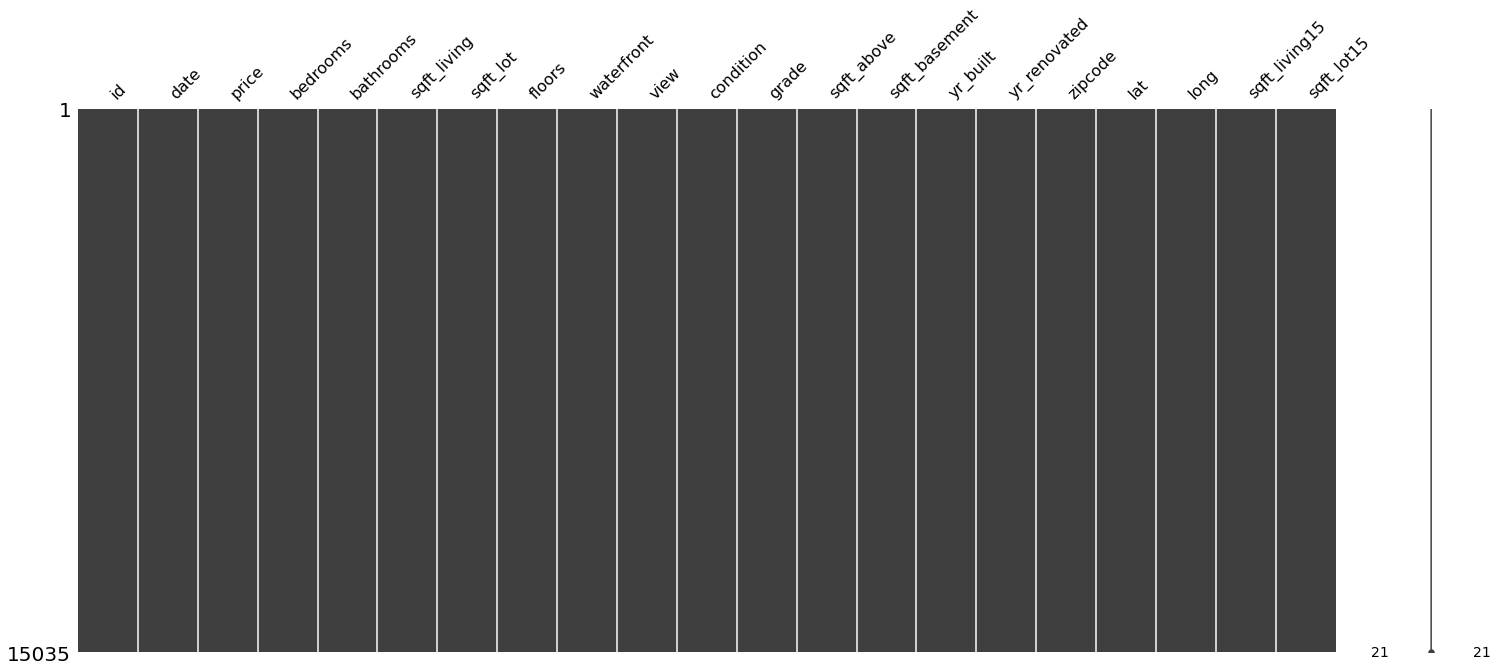

In [822]:
msno.matrix(train) # 혹여나 널 값 확인

In [823]:
# 더블체크

null_check = pd.isnull(train)
print(null_check)

          id   date  price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0      False  False  False     False      False        False     False   
1      False  False  False     False      False        False     False   
2      False  False  False     False      False        False     False   
3      False  False  False     False      False        False     False   
4      False  False  False     False      False        False     False   
...      ...    ...    ...       ...        ...          ...       ...   
15030  False  False  False     False      False        False     False   
15031  False  False  False     False      False        False     False   
15032  False  False  False     False      False        False     False   
15033  False  False  False     False      False        False     False   
15034  False  False  False     False      False        False     False   

       floors  waterfront   view  ...  grade  sqft_above  sqft_basement  \
0       False       False  False  ..

널 값이 없다는 것을 확인할 수 있다.

In [824]:
# 어떤 특성들이 중요할 지 가설을 세워보자

train.head(1000)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,20140626T000000,225000.0,3,2.00,1700,11475,1.0,0,0,...,6,970,730,1945,0,98146,47.4851,-122.338,1560,11475
996,996,20140917T000000,279200.0,1,1.00,640,6350,1.0,0,0,...,5,640,0,1939,0,98117,47.6976,-122.359,1270,6350
997,997,20140520T000000,520000.0,4,3.50,2680,10000,2.0,0,0,...,8,2040,640,1942,2014,98125,47.7260,-122.296,1530,8000
998,998,20140625T000000,505000.0,3,2.50,1860,8060,2.0,0,0,...,8,1860,0,1987,0,98029,47.5674,-122.017,1850,4661


yr_renovated, yr_built는 view로 대체 가능하기 때문에 필요 없어보인다.

ID 정보는 엄청나게 필요해 보이진 않는다.
date 집을 구매한 정보다 필요 없어 보인다.
zip code, lat, long이 비슷한 걸로 보아, 같은 동네인 것을 알 수 있다.
같은 동네라고  가정한다면, 집 값에 영향을 주지 않는다.


In [825]:
train = train[['id',	'date', 'price',	'bedrooms',	'bathrooms',	'sqft_living',	'sqft_lot',	'floors',	'waterfront',	'view',	'condition',	'grade',	'sqft_above',	'sqft_basement',	'yr_built',	'yr_renovated',	'zipcode',	'lat',	'long',	'sqft_living15',	'sqft_lot15']]

In [826]:
test = test[['id',	'date', 'bedrooms',	'bathrooms',	'sqft_living',	'sqft_lot',	'floors',	'waterfront',	'view',	'condition',	'grade',	'sqft_above',	'sqft_basement',	'yr_built',	'yr_renovated',	'zipcode',	'lat',	'long',	'sqft_living15',	'sqft_lot15']]

In [827]:
test = test[['bedrooms',  'bathrooms',	'sqft_living',	'sqft_lot',	'floors',	'waterfront',	'view',	'condition',	'grade',	'sqft_above',	'sqft_basement','sqft_living15','sqft_lot15']]

In [828]:
# 필요없는 항목 삭제

X = train[['bedrooms', 'price', 'bathrooms',	'sqft_living',	'sqft_lot',	'floors',	'waterfront',	'view',	'condition',	'grade',	'sqft_above',	'sqft_basement','sqft_living15','sqft_lot15']]

In [829]:
X.head() # 필요없는 항목들이 삭제 되었는 지 확인

,bedrooms,price,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15
0,3,221900.0,1.00,1180,5650,1.0,0,0,3,7,1180,0,1340,5650
1,2,180000.0,1.00,770,10000,1.0,0,0,3,6,770,0,2720,8062
2,3,510000.0,2.00,1680,8080,1.0,0,0,3,8,1680,0,1800,7503
3,3,257500.0,2.25,1715,6819,2.0,0,0,3,7,1715,0,2238,6819
4,3,291850.0,1.50,1060,9711,1.0,0,0,3,7,1060,0,1650,9711


In [830]:
# train모델과 test 모델을 구분해준다.

y = train['price']
del X['price']

In [831]:
X.shape, y.shape

((15035, 13), (15035,))

In [832]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(12028, 13) (12028,)
(3007, 13) (3007,)


# 선형회귀

In [833]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [834]:
model.fit(X_train, y_train)

LinearRegression()

In [835]:
predictions = model.predict(X_test)
predictions

array([424716.82034979, 435460.24041792, 320670.62517062, ...,
       298879.32029943, 500593.78408728, 354256.98302212])

In [836]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, predictions)
mse

49683543098.9445

In [837]:
# rmse

def rmse(x, y):
  return np.sqrt(mean_squqred_error(np.expm1(x), np.expm1(y)))


오류 값 범람 대실패

# Aferage Blending

In [838]:
train_data_path = ('/content/train.csv')
test_data_path = ('/content/test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [839]:
#카테고리 값 쓰기 위해 의미있는 수로 바꿔주기

train = pd.get_dummies(train, columns = ['yr_built', 'waterfront', 'zipcode'])
test = pd.get_dummies(test, columns = ['yr_built', 'waterfront', 'zipcode'])

In [840]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,3,...,0,0,0,0,0,0,1,0,0,0
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,3,...,0,0,0,0,0,0,0,0,0,0
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,3,...,0,0,0,0,0,0,0,0,0,0
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,3,...,0,0,0,0,0,0,0,0,0,0
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,3,...,0,0,0,0,0,0,0,0,1,0


In [841]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,3,...,0,0,0,0,0,0,1,0,0,0
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,3,...,0,0,0,0,0,0,0,0,0,0
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,3,...,0,0,0,0,0,0,0,0,0,0
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,3,...,0,0,0,0,0,0,0,0,0,0
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,3,...,0,0,0,0,0,0,0,0,1,0


In [842]:
#y에 정답값 넣기

y = train['price']
del train['price']

print(train.columns)
y.head()

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'view', 'condition', 'grade',
       ...
       'zipcode_98146', 'zipcode_98148', 'zipcode_98155', 'zipcode_98166',
       'zipcode_98168', 'zipcode_98177', 'zipcode_98178', 'zipcode_98188',
       'zipcode_98198', 'zipcode_98199'],
      dtype='object', length=205)


0    221900.0
1    180000.0
2    510000.0
3    257500.0
4    291850.0
Name: price, dtype: float64

In [843]:
# 선형회귀 때와 같이 카테고리를 지웠을 때, 스코어 대참사 남
# 여러번 시도해본 결과 이 두가지 값을 지우는 게 제일 나았다

del train['id'], train['date']

print(train.columns)

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view',
       'condition', 'grade', 'sqft_above', 'sqft_basement',
       ...
       'zipcode_98146', 'zipcode_98148', 'zipcode_98155', 'zipcode_98166',
       'zipcode_98168', 'zipcode_98177', 'zipcode_98178', 'zipcode_98188',
       'zipcode_98198', 'zipcode_98199'],
      dtype='object', length=203)


In [844]:
# train과 test column을 맞춰줘야 한다

test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id'], test['date']

print(test.columns)

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view',
       'condition', 'grade', 'sqft_above', 'sqft_basement',
       ...
       'zipcode_98146', 'zipcode_98148', 'zipcode_98155', 'zipcode_98166',
       'zipcode_98168', 'zipcode_98177', 'zipcode_98178', 'zipcode_98188',
       'zipcode_98198', 'zipcode_98199'],
      dtype='object', length=203)


In [845]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

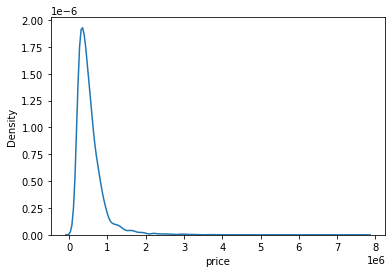

In [846]:
sns.kdeplot(y)
plt.show() 

값이 편향되어 있다는 것을 알 수 있다. 그래프 분포가 넓지 않으면, 예측 값이 편향되게 나올 수 있다.

In [847]:
# log를 이용하여, 값의 분포를 넓게 만들어보자

y = np.log1p(y)
y 

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

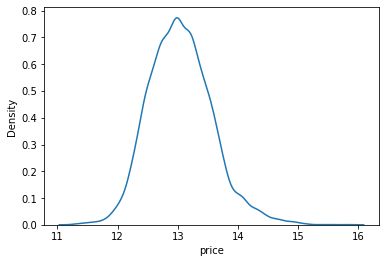

In [848]:
sns.kdeplot(y)
plt.show()

In [849]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Columns: 203 entries, bedrooms to zipcode_98199
dtypes: float64(4), int64(11), uint8(188)
memory usage: 4.4 MB


In [850]:
# rmse 오류값 측정 함수

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [851]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [852]:
# 여러 가지 함수로 돌려보자

random_state=10

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [853]:
def get_scores(models, train, y):
  df = {}
  
  for model in models:
    # 모델 이름 획득
      model_name = model.__class__.__name__

      # 모델 학습
      X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
      model.fit(X_train, y_train)
    
      # 예측
      y_pred = model.predict(X_test)

      # 예측 결과의 rmse값 저장
      df[model_name] = rmse(y_test, y_pred)
    
      # data frame에 저장
      score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

  return score_df

In [854]:
# 하이퍼 파라미터의 서막...

from sklearn.model_selection import GridSearchCV

In [855]:
param_grid = {
    'n_estimators': [608, 609, 610, 500],
    "max_depth" : [10, 9 ,8]
}

In [856]:
model = LGBMRegressor(random_state=random_state)

In [857]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                          scoring='neg_mean_squared_error', \
                          cv = 5, verbose=1, n_jobs=-1)
grid_model.fit(train, y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=10), n_jobs=-1,
             param_grid={'max_depth': [10, 9, 8],
                         'n_estimators': [608, 609, 610, 500]},
             scoring='neg_mean_squared_error', verbose=1)

In [858]:
grid_model.cv_results_

{'mean_fit_time': array([2.30293565, 2.35793715, 2.3456069 , 1.95257759, 2.4205801 ,
        2.30244155, 2.30082641, 1.96758323, 2.24574318, 2.30560288,
        2.23352046, 1.86061997]),
 'mean_score_time': array([0.22244492, 0.21645403, 0.21744223, 0.14634256, 0.21682215,
        0.2054965 , 0.20280075, 0.14133463, 0.17849646, 0.17764416,
        0.18379474, 0.13017845]),
 'mean_test_score': array([-0.02754396, -0.02754677, -0.02754796, -0.02739384, -0.02758655,
        -0.02758759, -0.02758837, -0.02745784, -0.02744376, -0.02744179,
        -0.02744145, -0.02732837]),
 'param_max_depth': masked_array(data=[10, 10, 10, 10, 9, 9, 9, 9, 8, 8, 8, 8],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[608, 609, 610, 500, 608, 609, 610, 500, 608, 609, 610,
                    500],
              mask=[False, False, False, Fa

정보가 너무 많다.

필요한 정보는 어떤 파라미터 조합일 때, 점수가 어떻게 나오는 지다.

파라미터 조합은 params에 저장되어 있고, 테스트 점수는 mean_test_score에 저장되어 있다.

In [859]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 10, 'n_estimators': 608},
 {'max_depth': 10, 'n_estimators': 609},
 {'max_depth': 10, 'n_estimators': 610},
 {'max_depth': 10, 'n_estimators': 500},
 {'max_depth': 9, 'n_estimators': 608},
 {'max_depth': 9, 'n_estimators': 609},
 {'max_depth': 9, 'n_estimators': 610},
 {'max_depth': 9, 'n_estimators': 500},
 {'max_depth': 8, 'n_estimators': 608},
 {'max_depth': 8, 'n_estimators': 609},
 {'max_depth': 8, 'n_estimators': 610},
 {'max_depth': 8, 'n_estimators': 500}]

In [860]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.02754396, -0.02754677, -0.02754796, -0.02739384, -0.02758655,
       -0.02758759, -0.02758837, -0.02745784, -0.02744376, -0.02744179,
       -0.02744145, -0.02732837])

In [861]:
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,10,608,-0.027544
1,10,609,-0.027547
2,10,610,-0.027548
3,10,500,-0.027394
4,9,608,-0.027587
5,9,609,-0.027588
6,9,610,-0.027588
7,9,500,-0.027458
8,8,608,-0.027444
9,8,609,-0.027442


왜 스코어가 음수일까 ??

MSE에 음수를 취한 값인 neg_mean_squared_error를 입력했기 때문

이를 해결해 주기 위해선

음수로 된 MSE를 -1곱해주고, np.sqrt루트 연산을 해준다

In [862]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,10,608,-0.027544,0.165964
1,10,609,-0.027547,0.165972
2,10,610,-0.027548,0.165976
3,10,500,-0.027394,0.165511
4,9,608,-0.027587,0.166092
5,9,609,-0.027588,0.166095
6,9,610,-0.027588,0.166097
7,9,500,-0.027458,0.165704
8,8,608,-0.027444,0.165662
9,8,609,-0.027442,0.165656


In [863]:
# 정규화를 위한 log를 씌워준다.

results = results.rename(columns={'RMSE' : 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,10,608,-0.027544,0.165964
1,10,609,-0.027547,0.165972
2,10,610,-0.027548,0.165976
3,10,500,-0.027394,0.165511
4,9,608,-0.027587,0.166092
5,9,609,-0.027588,0.166095
6,9,610,-0.027588,0.166097
7,9,500,-0.027458,0.165704
8,8,608,-0.027444,0.165662
9,8,609,-0.027442,0.165656


In [864]:
#오름차순 정렬

results = results.sort_values("RMSLE")
results

,max_depth,n_estimators,score,RMSLE
11,8,500,-0.027328,0.165313
3,10,500,-0.027394,0.165511
10,8,610,-0.027441,0.165655
9,8,609,-0.027442,0.165656
8,8,608,-0.027444,0.165662
7,9,500,-0.027458,0.165704
0,10,608,-0.027544,0.165964
1,10,609,-0.027547,0.165972
2,10,610,-0.027548,0.165976
4,9,608,-0.027587,0.166092


가장 좋은 조합은 max_depth = 8, n_estimators=500

In [865]:
# 해당 파라미터로 구성된 모델을 준비

model = LGBMRegressor(max_depth=8, n_estimators=608, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.10121536, 13.10316606, 14.151911  , ..., 13.06883401,
       12.67564884, 13.05461905])

In [866]:
# 예측 결과에 np.exam1()을 씌워서 다시 원래 스케일로 되돌린다.
prediction = np.expm1(prediction)
prediction

array([ 489536.01703062,  490491.88788643, 1399898.49528711, ...,
        473938.05241594,  319862.25168767,  467248.6840021 ])

In [867]:
submission_path = join('/content/sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [868]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,4.895360e+05
1,15036,4.904919e+05
2,15037,1.399898e+06
3,15038,3.046650e+05
4,15039,3.418841e+05


In [869]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    submission_path = ('/content/sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = 'submission_{}_RMSLE_{}.csv'.format(model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [871]:
save_submission(model, train, y, test, 'lgbm', rmsle='a')

submission_lgbm_RMSLE_a.csv saved!


# 회고

후련하다..오늘 출근 10시 부터 지금 12시...장장 14시간의 장정이 끝났다. 많은 사람들에게 도움을 받았다. 특히 무성님..같이 오랜 시간동안 고민해주셔서 감사합니다. random_state는 신입니다...

이 exploration을 끝내면서 가진 의문은 hyper-parameter가 최선일까요 ? 머리가 안 되면, 몸으로 떼우는 느낌을 많이 받았다. 이보다 더 이로운 함수를 빨리 체득하고 싶다는 생각을 가졌다.

그리고, 영태 님께서, parm_gird에 다른 요소가 있다는 고급정보를 줬다. 빨리 과제를 끝내고 싶은 마음에 혹은 코드를 더이상 치고 싶지 않은 마음에 아이디어 단계에서 멈췄다. 다음에 시간 된다면 이를 구현해보겠다.

어느 exploration 보다 많은 개념이 나왔다. 많은 시간 보고 생각을 했지만, 개념 확립이 부족하다. 더 열심히 공부해 확실히 체득하겠다. 

이 과제를 끝내는 시점 후련함 반, 찝찝함 반이다. 우연히 원하는 값과 일치한 거 같다. 가장 이상적인 파라미터를 가르쳐주는 함수가 알려준 값이 아닌 4번째 위치한 숫자가 답이었다니...더 정확하게 구현하기 위해 노력해야겠다. 이번 주 내로 확실하게 코드를 다시 한 번 찍어봐야겠다. 파이팅 !